Mark has prepared a table that, for each existing timestamp and channel combination, report the file path. In this notebook we try to load it and see how to integrate it in the data loader. The file is time ordered in ascending order, the first available date is 2010/05/01. We also plot some distributions of the dataset to understand if there are gaps, irregularities.

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [130]:
inventory_path = '/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML/inventory.pkl'

In [131]:
df=pd.read_pickle("/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML/inventory.pkl")

In [132]:
for col in df.columns:
    print(df[col].value_counts())

2017    734263
2018    729070
2013    721980
2015    721132
2011    714670
2016    710407
2014    707106
2012    702938
2010    391918
Name: year, dtype: int64
10    661898
7     660718
6     645203
8     641080
5     637133
9     612326
1     597908
3     570120
4     567224
2     539874
Name: month, dtype: int64
21    207613
15    207104
22    205866
25    204592
17    204457
19    204162
14    203990
7     203898
11    203769
27    203438
2     202768
24    202718
18    202695
16    202635
12    201642
10    201346
28    200397
1     199525
5     199339
13    198879
3     198854
26    198706
23    198181
20    197686
9     197592
8     197353
4     196428
6     194101
29    188151
30    183948
31    121651
Name: day, dtype: int64
1     264302
3     264219
4     264108
2     263962
5     263749
0     263235
12    262864
11    262750
10    262741
23    261850
13    260325
22    259869
9     259778
14    258786
17    256169
16    255726
8     255706
19    253137
15    253026
20    2510

In [270]:
bin_dict = dict(zip(['year','month', 'day', 'hour', 'min'], [8, 10, 31, 24, 10]))

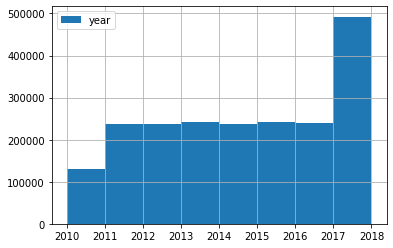

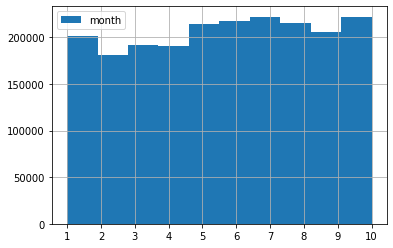

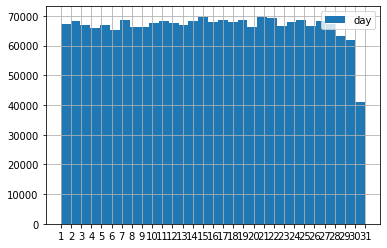

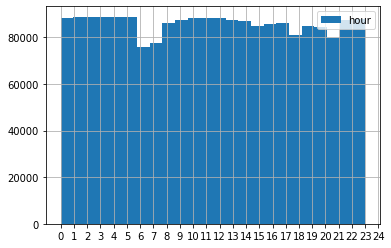

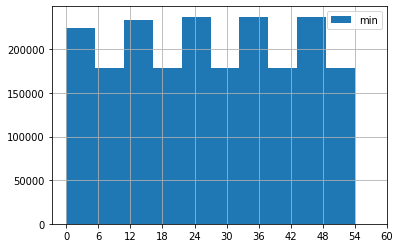

In [278]:
# we have the double of the data in 2018 (incresead time resolution?)
# the other distributions are pretty flat
# expected trend for minutes, every 12min we have also the bx,by,bz data
for col, bins in bin_dict.items():
    plt.figure()
    df[col].hist(label=col, bins=bins)
    if col == 'month':
        ticks = np.arange(1, 11)
    elif col == 'year':
         ticks = np.arange(2010, 2019)
    elif col == 'day':
         ticks = np.arange(1, 32)
    elif col == 'min':
         ticks = np.arange(0, 61, 6)
    else:
        ticks = np.arange(0, 25)        
    plt.xticks(ticks)
    plt.legend()
    i += 1

In [133]:
df.head()

,year,month,day,hour,min,channel,file
index,,,,,,,
1076941452,2010,5,1,0,12,by,/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML/2010/0...
1076941452,2010,5,1,0,12,bz,/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML/2010/0...
1076941452,2010,5,1,0,12,bx,/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML/2010/0...
1076941464,2010,5,1,0,24,bz,/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML/2010/0...
1076941464,2010,5,1,0,24,by,/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML/2010/0...


In [214]:
# let's try to select on channels, years, months, days, hours and minutes
index = ['year', 'month', 'day', 'hour', 'min']
channels = ['0094','0131','0171','bx']
yrs = np.arange(2011, 2012)
months = np.arange(1,10,1)
days = np.arange(1,32,7)
hours = np.arange(0, 25, 12)
minus = np.arange(0, 61, 12)

In [215]:
cond0 = df['channel'].isin(channels)
cond1 = df['year'].isin(yrs)
cond2 = df['month'].isin(months)
cond3 = df['day'].isin(days)
cond4 = df['hour'].isin(hours)
cond5 = df['min'].isin(minus)
sel_df = df[cond0 & cond1 & cond2 & cond3 & cond4 & cond5]
sel_df.groupby(index).head(1).shape[0]

440

In [216]:
grouped_df = sel_df.groupby(index).size()
# we select only timestamp that have files for all the channels
grouped_df = grouped_df[grouped_df == len(channels)].to_frame()
sel_df = sel_df.reset_index().drop('index', axis=1)
sel_df = pd.merge(grouped_df, sel_df, how='inner', left_on=index, right_on=index)

In [217]:
# sorting is essential, otherwise at each step the order of the channels will not be consistent
s_files = sel_df.sort_values('channel').groupby(index)['file'].apply(list)

In [218]:
results = tuple(zip(s_files,s_files.index))

In [219]:
tuple(zip(s_files.values.tolist(), s_files.index.tolist()))[0]

(['/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML/2011/01/01/AIA20110101_0000_0094.npz',
  '/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML/2011/01/01/AIA20110101_0000_0131.npz',
  '/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML/2011/01/01/AIA20110101_0000_0171.npz',
  '/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML/2011/01/01/HMI20110101_0000_bx.npz'],
 (2011, 1, 1, 0, 0))

In [220]:
len(s_files.index.tolist())

422

Okay this seems a strategy that is quick enough, it will be applied in the sdo dataset, in replacement of the previous version.